## Example notebook running SiRCle

In [1]:
from scircm import SciRCM
import pandas as pd

# FORMAT must be csv :) 
data_dir = 'data/'
prot_file = f'{data_dir}prot_DE_Stage IV_sircle.csv'
rna_file = f'{data_dir}rna_DE_Stage IV_sircle.csv'
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'



### Had to run this originally but couldn't upload the data since the file was too big
```
from scircm import filter_methylation_data_by_genes
import numpy as np
meth_df = pd.read_csv(meth_file)
# Note: you need to pass it: 
# 1) the gene ID column, here it is 'ensembl_gene_id'
# 2) the padj column: here it is 'padj_meth'
# 3) the logFC or test statistic column: here it is 'CpG_Beta_diff'
# Since we don't have a beta diff between normal and tumour let's make one (used M values)
meth_df['CpG_Beta_diff'] = np.mean(meth_df[[c for c in meth_df.columns if 'Tumor' in c]].values) - np.mean(meth_df[[c for c in meth_df.columns if 'Normal' in c]].values)
filtered_meth_df = filter_methylation_data_by_genes(meth_df, 'ensembl_gene_id', 'padj_meth', 'CpG_Beta_diff')
# Re point the meth file to be the filtered one
meth_file = f'{data_dir}filtered_cpg_DE_Stage IV_sircle.csv'
filtered_meth_df.to_csv(meth_file, index=False)
```

## Have a look at each DF to show what is in it

In [2]:
pd.read_csv(prot_file)

,external_gene_name,ensembl_gene_id,chromosome_name,start_position,end_position,strand,entrezgene_id,external_synonym,hgnc_symbol,original_gene_id,...,Protein_Tumor_C3N.01200_CPT0075130003,Protein_Normal_C3N.01220_CPT0076350001,Protein_Tumor_C3N.01220_CPT0076330003,logFC_protein,stat_protein,pvalue_protein,padj_protein,B_protein,mean_protein,var_protein
0,IFITM2,ENSG00000185201,11,303655.0,309397.0,1.0,10581.0,1-8D,IFITM2,IFITM2,...,17.330488,17.219003,17.368543,0.058697,0.759486,4.548756e-01,0.552655,-6.717889,17.336464,0.035891
1,IFITM3,ENSG00000142089,11,319676.0,329475.0,-1.0,10410.0,1-8U,IFITM3,IFITM3,...,21.389833,20.624301,21.268696,0.342514,4.407527,1.833464e-04,0.000666,0.337124,21.053427,0.066014
2,PRDX6,ENSG00000117592,1,173477330.0,173488815.0,1.0,9588.0,1-Cys,PRDX6,PRDX6,...,25.942430,26.157340,26.136880,-0.053029,-0.852348,4.023229e-01,0.501836,-6.642658,26.016635,0.022394
3,ALDH1L1,ENSG00000144908,3,126103562.0,126197994.0,-1.0,10840.0,10-fTHF,ALDH1L1,ALDH1L1,...,24.198385,25.787163,24.507928,-0.894437,-5.830075,5.017052e-06,0.000031,3.902914,24.983542,0.354569
4,KNOP1,ENSG00000103550,16,19701937.0,19718235.0,-1.0,400506.0,101F10.1,KNOP1,KNOP1,...,18.239034,17.378866,17.962233,0.554211,6.769885,5.038201e-07,0.000005,6.194251,17.687298,0.119714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350,ZNF827,ENSG00000151612,4,145757627.0,145938823.0,-1.0,152485.0,NaN,ZNF827,ZNF827,...,16.217080,16.252160,16.008280,-0.096421,-0.706508,4.866184e-01,0.583480,-6.757103,16.415587,0.117283
11351,ZNF865,ENSG00000261221,19,55605647.0,55617269.0,1.0,100507290.0,NaN,ZNF865,ZNF865,...,18.350170,18.384890,18.371440,-0.034837,-0.500347,6.213235e-01,0.704386,-6.883668,18.382762,0.028185
11352,ZNF888,ENSG00000213793,19,52904415.0,52923470.0,-1.0,388559.0,NaN,ZNF888,ZNF888,...,14.805210,14.598660,14.825800,0.148483,5.213043,2.319997e-05,0.000113,2.377486,14.738168,0.007968
11353,ZNRD1,ENSG00000066379,NaN,NaN,NaN,NaN,30834.0,NaN,POLR1H,ZNRD1,...,18.610100,18.353800,18.569210,0.096586,1.143102,2.641749e-01,0.359737,-6.355088,18.508131,0.044773


In [3]:
pd.read_csv(rna_file) # Note we can see that the ensembl gene ID column is named Unnamed: 0 this is 
# From DESeq2 having it as the row name

,Unnamed: 0,external_gene_name,entrezgene_id,hgnc_symbol,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,baseMean_rna,...,RNA_Tumor_C3N.00577_3,RNA_Normal_C3N.01200_1,RNA_Tumor_C3N.01200_1,RNA_Tumor_C3N.01200_2,RNA_Tumor_C3N.01200_3,RNA_Tumor_C3N.01200_4,RNA_Normal_C3N.01220_1,RNA_Tumor_C3N.01220_1,RNA_Tumor_C3N.01220_2,RNA_Tumor_C3N.01220_3
0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,1794.558447,...,5.434883,5.599905,4.629352,4.891962,4.593554,4.837085,5.613410,4.249658,4.867085,5.134165
1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,48.809118,...,0.529242,0.948905,0.229404,0.652659,0.677917,0.291472,1.126509,0.282126,0.610286,0.735218
2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,1236.222835,...,5.223657,4.821487,5.428061,4.756430,4.723433,4.983125,4.658032,5.531724,5.371377,5.379116
3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.007758,-0.104059,9.171225e-01,9.387892e-01,0.074558,1133.146419,...,4.929975,4.745831,4.580305,4.764627,4.647780,4.773554,4.739300,4.750514,4.883110,4.904443
4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,412.698772,...,3.433213,2.969224,3.896414,3.577152,3.593571,3.971502,2.658574,2.988328,3.266873,3.487473
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33763,ENSG00000281896,NaN,NaN,NaN,-0.098954,-0.695917,4.864808e-01,5.724860e-01,0.142192,206.580354,...,2.509036,2.618644,2.719000,2.450616,2.643508,2.599286,2.519339,2.802318,2.395787,2.447740
33764,ENSG00000281903,LINC02246,NaN,LINC02246,-0.311020,-1.488246,1.366861e-01,1.974510e-01,0.208984,65.953130,...,0.974198,1.440372,2.024264,1.418020,1.364319,1.548652,1.616073,1.183909,1.448970,1.378556
33765,ENSG00000281910,SNORA50A,677830.0,SNORA50A,0.709131,3.867430,1.099884e-04,3.467546e-04,0.183360,23.625336,...,0.723971,0.398676,0.463802,0.569543,0.584824,0.760479,0.660739,0.634094,0.849903,1.024248
33766,ENSG00000281912,LINC01144,400752.0,LINC01144,-0.638175,-2.901953,3.708440e-03,8.291506e-03,0.219912,36.353359,...,1.011987,0.526789,0.601271,0.787500,0.887335,0.488513,1.154666,1.286824,0.928030,1.204567


In [4]:
rna_df = pd.read_csv(rna_file)
rna_df.rename(columns={'Unnamed: 0': 'ensembl_gene_id'}, inplace=True)
rna_df.to_csv(f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv', index=False)
rna_file = f'{data_dir}rna_DE_Stage IV_sircle_renamed-cols.csv'

In [5]:
pd.read_csv(meth_file)

,Unnamed: 0,Locus,chr,pos,Relation_to_Island,UCSC_RefGene_Group,ensembl_gene_id,external_gene_name,hgnc_symbol,entrezgene_id,...,CpG_Normal_2ff2d2ea.9b26.487e.be22.e99d42cc2edb_1,CpG_Normal_db23dcfc.0126.49c5.9705.6e1b79fc7df1_1,CpG_Normal_1660d8a3.5f2d.45a4.820a.aa4990b75a8a_1,CpG_Normal_93eeec61.0fa3.43d0.98b5.6d8acd8e69f1_1,CpG_Normal_1a35f502.10c0.4e9b.8274.5494ea50fff5_1,CpG_Normal_62bcce15.fdaf.49d4.9bed.24a493f5776b_1,CpG_Normal_e3ed1380.d6f1.420e.b6a6.d24a6e81a364_1,CpG_Normal_cb371398.ee48.4665.8089.26229c5b2cf0_1,CpG_Normal_ef9ae1dd.83aa.404d.83ef.ced707ae738b_1,CpG_Beta_diff
0,cg01473187,cg01473187,chrX,100636165,N_Shore,Body,ENSG00000000003,TSPAN6,TSPAN6,7105,...,0.180325,0.473674,0.290601,0.366690,0.213985,0.299311,0.302644,0.368436,0.190726,-0.035676
1,cg16822540,cg16822540,chrX,100584849,OpenSea,1stExon;5'UTR,ENSG00000000005,TNMD,TNMD,64102,...,0.906177,0.630440,0.860365,0.777538,0.726988,0.818062,0.881122,0.849243,0.916830,-0.035676
2,cg14741366,cg14741366,chr20,50955031,N_Shelf,Body,ENSG00000000419,DPM1,DPM1,8813,...,0.973954,0.907073,0.954293,0.934954,0.901875,0.940070,0.950324,0.944920,0.953963,-0.035676
3,cg08245509,cg08245509,chr1,169894353,S_Shore,TSS1500;TSS1500,ENSG00000000457,SCYL3,SCYL3,57147,...,0.057217,0.105343,0.077352,0.086249,0.135714,0.098847,0.039106,0.044032,0.069995,-0.035676
4,cg06093460,cg06093460,chr1,169733700,OpenSea,5'UTR,ENSG00000000460,C1orf112,C1orf112,55732,...,0.873928,0.832325,0.885978,0.861265,0.786526,0.842439,0.840169,0.899528,0.922147,-0.035676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20842,cg12710480,cg12710480,chr20,33666410,N_Shore,Body;Body;TSS200,ENSG00000288649,ACTL10,ACTL10,170487,...,0.258528,0.233961,0.247719,0.166719,0.239548,0.213720,0.266057,0.216800,0.197770,-0.035676
20843,cg11272349,cg11272349,chr2,233728607,OpenSea,Body;Body;Body;Body;Body;Body;Body;Body;TSS1500,ENSG00000288702,UGT1A3,UGT1A3,54659,...,0.912709,0.922216,0.870761,0.884178,0.925671,0.955566,0.886615,0.858294,0.918659,-0.035676
20844,cg23841280,cg23841280,chr2,233713467,OpenSea,Body;Body;Body;Body;Body;1stExon;Body,ENSG00000288705,UGT1A5,UGT1A5,54579,...,0.863748,0.899406,0.822945,0.843668,0.919372,0.889941,0.846407,0.841862,0.862782,-0.035676
20845,cg08037664,cg08037664,chrX,154885717,N_Shore,Body;TSS1500;TSS1500;Body;TSS1500,ENSG00000288722,F8A1,F8A1,8263,...,0.803331,0.815880,0.728846,0.744514,0.860594,0.820578,0.734450,0.705725,0.800652,-0.035676


## Run SiRCle

In [6]:
# Note we assume your methylation CpGs map to a single gene, if they don't see the section below.
# logFC_rna = column name in your RNA file that has your RNA logFC (same for the protein and CpG)
# padj_rna = column name in your RNA file that has your padj value (same for protein and CpG)
# NOTE: these need to be unique from one another since we merge the datasets, if they aren't, you need
# to update your csv files.
# Lastly: ensembl_gene_id this is the gene ID column, All must use the same identifier, and this must be
# labelled the same in each file, if it isn't, update your column names before running.
rcm = SciRCM(meth_file, rna_file, prot_file, 
             "logFC_rna", "padj_rna", "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein",
             "ensembl_gene_id", sep=',',
             rna_padj_cutoff=0.05, 
             prot_padj_cutoff=0.05, 
             meth_padj_cutoff=0.05,
             rna_logfc_cutoff=1.0, 
             prot_logfc_cutoff=0.5, 
             meth_diff_cutoff=0.1, 
             output_dir='',
             non_coding_genes=['None'],
             output_filename='RCM_Output.csv',
             bg_type = '(P&M)|(P&R)|(M&R)'
         )
rcm.run()
df = rcm.get_df()
# That DF now has your rcm clustering results, how easy was that :D
df # The three columns you now have are: Regulation_Grouping_1, Regulation_Grouping_2, Regulation_Grouping_3

--------------------------------------------------------------------------------
Protein dataset contained duplicates based on ID! Dropping duplicate IDs, note you should do this before running SiRCle. We have just dropped it and kept the first entry. You had: 	14	duplicates.	
--------------------------------------------------------------------------------


,ensembl_gene_id,external_gene_name_r,entrezgene_id_r,hgnc_symbol_r,logFC_rna,stat_rna,pvalue_rna,padj_rna,lfcSE_rna,baseMean_rna,...,Protein,RG1_All,RG2_Changes,RG3_Translation,RG4_Detection,Background_filter,RG1_All_filtered,RG2_Changes_filtered,RG3_Translation_filtered,RG4_Detection_filtered
0,ENSG00000000003,TSPAN6,7105.0,TSPAN6,-0.867335,-4.447026,8.706735e-06,3.453242e-05,0.195037,1794.558447,...,Protein DOWN,Methylation No change + RNA No change + Protei...,TMDS,TMDS,TMDS,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,TMDS,TMDS,TMDS
1,ENSG00000000005,TNMD,64102.0,TNMD,-1.047049,-2.266892,2.339680e-02,4.256510e-02,0.461887,48.809118,...,Protein Undetected,Methylation No change + RNA DOWN + Protein Und...,TPDS_TMDE,TPDS,TPDS,threshold + threshold + NS,Methylation No change + RNA DOWN + Protein Und...,TPDS_TMDE,TPDS,TPDS
2,ENSG00000000419,DPM1,8813.0,DPM1,0.517629,3.599892,3.183492e-04,9.048072e-04,0.143790,1236.222835,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,None,None,None
3,ENSG00000000457,SCYL3,57147.0,SCYL3,-0.007758,-0.104059,9.171225e-01,9.387892e-01,0.074558,1133.146419,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + threshold,Methylation No change + RNA No change + Protei...,None,None,None
4,ENSG00000000460,C1orf112,55732.0,C1orf112,0.731784,5.833491,5.427942e-09,3.752697e-08,0.125445,412.698772,...,Protein Undetected,Methylation No change + RNA No change + Protei...,None,None,None,threshold + threshold + NS,Methylation No change + RNA No change + Protei...,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38168,ENSG00000235376,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38169,ENSG00000213648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38170,ENSG00000124208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein significant-positive,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background
38171,ENSG00000283900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Protein not-significant,Methylation No change + RNA No change + Protei...,None,None,None,NS + NS + threshold,Not-Background,Not-Background,Not-Background,Not-Background


## Plot the clusters

Text(0.5, 1.0, 'Clustered Stage IV patients')

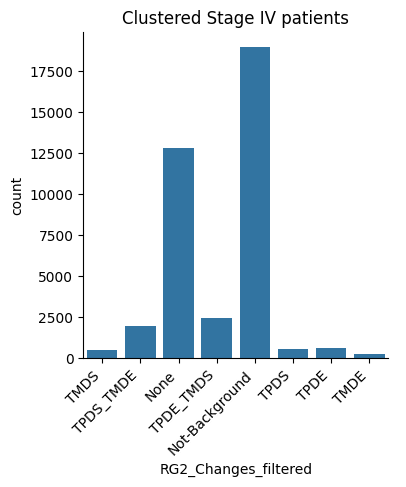

In [7]:
import itertools
from matplotlib import rcParams
import matplotlib.pyplot as plt
import seaborn as sns

g = sns.catplot(data=df, x='RG2_Changes_filtered', kind="count", 
               height=4)
plt.xticks(rotation=45, ha='right')
plt.title(f'Clustered Stage IV patients')

### Save DF to a file

In [8]:
df.to_csv(f'{data_dir}RCM.csv', index=False)

## Look at enriched TF's

/Users/arianemora/miniconda3/envs/scircm/lib/python3.8/site-packages/scimotf/doro.py:142: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  self.cluster_df = pd.read_csv(self.cluster_file)


--------------------------------------------------------------------------------
WARN: no background ID set, using all genes in the supplied DF as the background.
Number of genes: 	1087	
--------------------------------------------------------------------------------
     Unnamed: 0  tf confidence  target  mor
481         482  AR          A  ACAD10    1
499         500  AR          A     CD4    1
503         504  AR          A  CDKN1A    1
506         507  AR          A    CPT2    1
508         509  AR          A    CYCS    1


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 214.78it/s]


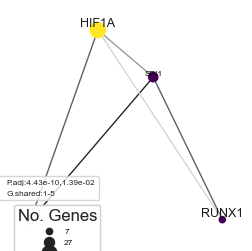

<Figure size 300x300 with 0 Axes>

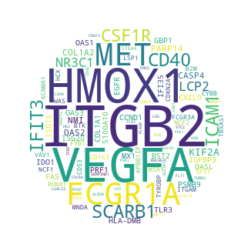

In [9]:
from scimotf import SciMotf_Doro
from scimotf import plot_cluster_tf

rcm_file = f'{data_dir}RCM.csv'
tf_file = f'{data_dir}dorothea_hs_ABCD.csv'
mo = SciMotf_Doro(doro_file=tf_file, cluster_file=rcm_file, 
                  cluster_id='RG2_Changes_filtered',
                  cluster_gene_id='external_gene_name', # got to match motif
                  padj_protein='padj_protein', logfc_protein='logFC_protein', padj_rna='padj_rna',
                  logfc_rna='logFC_rna', output_dir=data_dir)

df = mo.run(['A'], rcm_clusters=["TMDE", "TMDS", "MDS", "MDE", "TPDE", "TPDS"])
df.to_csv(f'{data_dir}scimotif_DORO_A.csv')
plot_cluster_tf(f'{data_dir}scimotif_DORO_A.csv', save_fig=False)

## Train model and compare two groups

### First setup the data

In [10]:
# Load in the files that we used for DE analysis and remove any redundent columns
# the VAE excpets just the ID as the index, and then the values
df = pd.read_csv(f'{data_dir}RCM.csv')

# First filter out any NA values (we're not interested in non SiRCle genes)
rcm_df = df[df['RG2_Changes_filtered'] != 'None']

rna_sample_file = f'{data_dir}rna_sample_data_Stage IV_sircle.csv'
prot_sample_file = f'{data_dir}prot_sample_data_Stage IV_sircle.csv'
# Now we want to merge the clinical info with the cases from the sample df
meth_sample_file = f'{data_dir}cpg_sample_data_Stage IV_sircle.csv'

rna_samples = list(pd.read_csv(rna_sample_file)['FullLabel'].values)
prot_samples = list(pd.read_csv(prot_sample_file)['FullLabel'].values)
meth_samples = list(pd.read_csv(meth_sample_file)['FullLabel'].values)
# Only use the filtered i.e. one CpG to one gene mapping for the cpg data

# ensembl_gene_id that same shared gene ID
cpg_data_df = rcm_df[['ensembl_gene_id'] + meth_samples]
rna_data_df = rcm_df[['ensembl_gene_id'] + rna_samples]
protein_data_df = rcm_df[['ensembl_gene_id'] + prot_samples]


meta_cols = ['ensembl_gene_id', 'external_gene_name', 'entrezgene_id', 'hgnc_symbol', "logFC_rna", "padj_rna", 
             "CpG_Beta_diff", "padj_meth", "logFC_protein", "padj_protein", "RG2_Changes_filtered"]


# Save to input dir
save_input_data = True
meta_rcm_df = rcm_df[meta_cols].copy()
meta_rcm_df.set_index('ensembl_gene_id', inplace=True)
# Save to the input data dir folder.
if save_input_data:
    protein_data_df.to_csv(f'{data_dir}CPTAC_protein.csv', index=False)
    rna_data_df.to_csv(f'{data_dir}CPTAC_rna.csv', index=False)
    cpg_data_df.to_csv(f'{data_dir}CPTAC_cpg.csv', index=False)
    meta_rcm_df.to_csv(f'{data_dir}RCM.csv')

/var/folders/sj/4wqsfdtd6093v9746b0t3mq40000gn/T/ipykernel_21888/2803628555.py:3: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f'{data_dir}RCM.csv')


In [11]:
# Example sample data frame
pd.read_csv(rna_sample_file)

,Unnamed: 0,SampleId,CondId,FullLabel,CondName,SafeCases,gender,TumorStage,AgeGrouped,BMIGrouped,...,CIMPStatus,GenomeInstability,VHL+TTN,VHL-TTN,VHL+PBRM1,VHL-PBRM1,PBRM1-VHL,VHL,TTN-VHL,TTN+PBRM1-VHL
0,C3L-00011,6b60f8f0-8e63-4669-b923-3023190d52e7,0,RNA_Normal_C3L.00011_1,Normal,C3L.00011,Female,Stage IV,old,between,...,1,1,1,0,0,1,0,0,0,0
1,C3L-00011,d203d100-f6f3-48f6-bb11-0195a86769d1,1,RNA_Tumor_C3L.00011_1,Tumor,C3L.00011,Female,Stage IV,old,between,...,1,1,1,0,0,1,0,0,0,0
2,C3L-00096,30a1f914-0dde-4f60-ae21-1d5d33c5f6f0,0,RNA_Normal_C3L.00096_1,Normal,C3L.00096,Male,Stage IV,middle,between,...,1,0,0,1,0,1,0,1,0,0
3,C3L-00096,52447ca4-bf8a-4c63-9979-58a2bf548b40,1,RNA_Tumor_C3L.00096_1,Tumor,C3L.00096,Male,Stage IV,middle,between,...,1,0,0,1,0,1,0,1,0,0
4,C3L-01281,5e27240a-a5a0-4b2c-80a6-91f08ad36098,0,RNA_Normal_C3L.01281_1,Normal,C3L.01281,Male,Stage IV,old,between,...,0,0,0,1,1,0,0,0,0,0
5,C3L-01281,226d1c49-68e8-4397-87ae-650968498832,1,RNA_Tumor_C3L.01281_1,Tumor,C3L.01281,Male,Stage IV,old,between,...,0,0,0,1,1,0,0,0,0,0
6,C3L-01287,bd806985-4de7-4f07-8559-bc1692d03937,0,RNA_Normal_C3L.01287_1,Normal,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
7,C3L-01287,ce55e102-f45f-4ea0-bc72-ab19482a9645,1,RNA_Tumor_C3L.01287_1,Tumor,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
8,C3L-01287,0a1a14f8-3e7a-44ae-a7ef-c0ae33a66975,1,RNA_Tumor_C3L.01287_2,Tumor,C3L.01287,Male,Stage IV,old,between,...,1,0,0,1,0,1,0,1,0,0
9,C3N-00149,af2f69dd-738e-4d3a-bc9b-75b8872a68cf,0,RNA_Normal_C3N.00149_1,Normal,C3N.00149,Female,Stage IV,old,between,...,1,1,0,1,0,1,0,1,0,0


### Next train the model

In [34]:
###############################################################################
#                                                                             #
#    This program is free software: you can redistribute it and/or modify     #
#    it under the terms of the GNU General Public License as published by     #
#    the Free Software Foundation, either version 3 of the License, or        #
#    (at your option) any later version.                                      #
#                                                                             #
#    This program is distributed in the hope that it will be useful,          #
#    but WITHOUT ANY WARRANTY; without even the implied warranty of           #
#    MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the            #
#    GNU General Public License for more details.                             #
#                                                                             #
#    You should have received a copy of the GNU General Public License        #
#    along with this program. If not, see <http://www.gnu.org/licenses/>.     #
#                                                                             #
###############################################################################
import random

from statsmodels.stats.multitest import multipletests
from scivae import VAE
from scipy import stats
import numpy as np
import pandas as pd
from sciutil import SciUtil
import json


class RCMStats:
    """
    Enables running a VAE on the RCM data.

    Takes in the output of rcm and then for each SiRCLe cluster, trains a VAE. It returns the dataset which can be
    used as input to calculating statistics on the DS.
    """

    def __init__(self, rcm_file: str,
                 patient_sample_file : str,
                 meth_file: str,
                 meth_sample_file: str,
                 rna_file: str,
                 rna_sample_file: str,
                 protein_file: str,
                 protein_sample_file: str,
                 output_folder: str,
                 condition_column: str,
                 column_id: str,
                 patient_id_column: str,
                 config_file: str = None,
                 regulatory_label='Regulation_Grouping_2',
                 run_name: str = None,
                 clinical_label: str = None,
                 normalise='rows', verbose=False, missing_method='mean',
                 iid=False):
        self.config_json = f'{config_file}'
        self.clinical_label = clinical_label
        self.feature_columns = ['RNA-LogFC',
                                'Protein-LogFC',
                                'CpG-LogFC',
                                'RNA-Tumor',
                                'RNA-Normal',
                                'Protein-Tumor',
                                'Protein-Normal']
        # Read in the data
        self.regulatory_label = regulatory_label
        self.rcm = pd.read_csv(rcm_file, index_col=0)
        self.meth_data = pd.read_csv(meth_file, index_col=0)
        self.rna_data = pd.read_csv(rna_file, index_col=0)
        self.protein_data = pd.read_csv(protein_file, index_col=0)
        self.run_name = run_name
        # Read in the sample dfs
        self.patient_id_column = patient_id_column  # This needs to be the same in all cases!
        self.patient_clinical_df = pd.read_csv(patient_sample_file)
        self.meth_sample_df = pd.read_csv(meth_sample_file)
        self.rna_sample_df = pd.read_csv(rna_sample_file)
        self.protein_sample_df = pd.read_csv(protein_sample_file)
        self.condition_column = condition_column or 'condition_id'
        self.column_id = column_id or 'column_id'
        self.missing_method = missing_method # either 'mean' or 'clinical'
        # For each of these files, normalise the rows to be between 0 and 1.
        self.output_folder = output_folder
        self.encoded_df = {}  # The encoded patient data.
        self.trained_vae = {}
        self.vae_input_df = {}
        self.train_df = {}
        self.raw_input_df = {} # The raw input data (i.e. no normaliseation).
        self.normalise = normalise
        self.u = SciUtil(debug_on=verbose)  # Set this optionally for verbosity
        self.u.warn_p(["WARNING: you cannot have underscores in your case_id names. Please check this before using"
                       "this tool."])
        self.check_files()
        self.iid = iid

    def save(self):
        """
        Save relevant files.

        Returns
        -------

        """
        encoded_df = pd.DataFrame()
        input_df = pd.DataFrame()
        raw_df = pd.DataFrame()
        for reg_label in self.encoded_df:
            df = self.encoded_df[reg_label]
            df[self.regulatory_label] = reg_label
            encoded_df = pd.concat([encoded_df, df])
            df = self.vae_input_df[reg_label]
            df[self.regulatory_label] = reg_label
            input_df = pd.concat([input_df, df])
            df = self.raw_input_df[reg_label]
            df[self.regulatory_label] = reg_label
            raw_df = pd.concat([raw_df, df])
        encoded_df.to_csv(f'{self.output_folder}encoded_df_{self.run_name}.csv')
        input_df.to_csv(f'{self.output_folder}vae_input_df_{self.run_name}.csv')
        raw_df.to_csv(f'{self.output_folder}raw_input_df_{self.run_name}.csv')

        # Also save the patient info
        self.patient_clinical_df.to_csv(f'{self.output_folder}patient_info_{self.run_name}.csv', index=False)

    def load_saved_vaes(self):

        for reg_label in self.rcm[self.regulatory_label].unique():
            try:
                weight_file_path = f'{self.output_folder}{reg_label}-{self.run_name}-VAE-weights.h5'
                optimizer_file_path = f'{self.output_folder}{reg_label}-{self.run_name}-VAE-optimizer.json'
                config_json = f'{self.output_folder}{reg_label}-{self.run_name}-VAE-config.json'
                with open(config_json, "r") as fp:
                    config = json.load(fp)
                vae_m = VAE(np.ones((20, len(self.feature_columns))), np.ones((20, len(self.feature_columns))),
                            list(np.ones(20)), config, vae_label=reg_label)
                # Then decode the data
                vae_m.load(weight_file_path, optimizer_file_path, config_json)
                self.trained_vae[reg_label] = vae_m
            except:
                self.u.warn_p(["Warning: Regulatory label: ", reg_label, " had no data"])
    def load_saved_inputs(self, filename):
        """
        Optionally load a saved version of the input/training data patient data. Expected to have "id" as the
        first column, then the cases and values, and the regulatory label for that gene.
        Parameters
        ----------
        filename

        Returns
        -------

        """
        input_df = pd.read_csv(filename, index_col=0)
        for reg_label in self.rcm[self.regulatory_label].unique():
            self.vae_input_df[reg_label] = input_df[input_df[self.regulatory_label] == reg_label]

    def load_saved_raws(self, filename):
        """
        Optionally load a saved version of the input/training data patient data. Expected to have "id" as the
        first column, then the cases and values, and the regulatory label for that gene.
        Parameters
        ----------
        filename

        Returns
        -------

        """
        input_df = pd.read_csv(filename, index_col=0)
        for reg_label in self.rcm[self.regulatory_label].unique():
            self.raw_input_df[reg_label] = input_df[input_df[self.regulatory_label] == reg_label]

    def load_saved_encodings(self, filename):
        """
        Optionally load a saved version of the encoded patient data. Expected to have "id" as the
        first column, then the cases and values, and the regulatory label for that gene.
        Parameters
        ----------
        filename

        Returns
        -------

        """
        input_df = pd.read_csv(filename, index_col=0)
        for reg_label in self.rcm[self.regulatory_label].unique():
            self.encoded_df[reg_label] = input_df[input_df[self.regulatory_label] == reg_label]

    def check_files(self):
        """
        We need to check the loaded files to make sure they are in the correct format.

        Checks:
            1. The index of each of the data files overlaps with the regulatory clusters.
            2. Each sample file must have a) condition_column (default = 'condition_id') which has values 1 = tumour or
            0 = Normal and b) a column ID field (default = 'column_id') that maps to the column of that dataset,
            c) a case ID (that is a patient ID: default='case_id' that maps to a patient ID in the patient_clinical_df
            which has clinical information about the patient. case_ids can't have underscores in them.
        Returns
        -------

        """
        # Check 1.
        rcm_genes = set(self.rcm.index.values)
        protein_genes = set(self.protein_data.index.values)
        rna_genes = set(self.rna_data.index.values)
        meth_genes = set(self.meth_data.index.values)
        total_overlap = len(rcm_genes & rna_genes & protein_genes & meth_genes)
        self.u.dp(['Overlap between SiRCLe gene clusters and protein, RNA, and CpG: ', total_overlap, '\n',
                   f'If you used SiRCLe, this should be the total number of genes in your SiRCLe dataset. '
                   f'{len(rcm_genes)}', '\n First 5 gene IDs in RCM: ', list(rcm_genes)[0:5],
                   '\n First 5 gene IDs in Protein: ', list(protein_genes)[0:5],
                   '\n First 5 gene IDs in RNA: ', list(rna_genes)[0:5],
                   '\n First 5 gene IDs in Methylation: ', list(meth_genes)[0:5],
                   ])
        if total_overlap == 0:
            self.u.err_p(['You had no overlap between your gene identifiers! That is not good, nothing will work.'
                          'Please make sure your gene IDs are matching and are in the first column of your CSV file.'
                          '\nAlso ensure you are using a CSV not a TSV.'])
            return

        # Part 2.
        if not self.check_cols_exist():
            return

        # Part 3. Check for duplicates
        if len(self.protein_data[self.protein_data.index.duplicated()]) > 0:
            num_dups = len(self.protein_data[self.protein_data.index.duplicated()])
            self.u.warn_p(['Protein dataset contained duplicates! Dropping duplicate IDs, note you should do this '
                           'before running SiRCle. We have just dropped it and kept the first entry. You had: ',
                           num_dups, 'duplicates.'])
            self.protein_data = self.protein_data[~self.protein_data.index.duplicated(keep='first')]
        if len(self.rna_data[self.rna_data.index.duplicated()]):
            num_dups = len(self.rna_data[self.rna_data.index.duplicated()])
            self.u.warn_p(['RNA dataset contained duplicates! Dropping duplicate IDs, note you should do this '
                           'before running SiRCle. We have just dropped it and kept the first entry. You had: ',
                           num_dups, 'duplicates.'])
            self.rna_data = self.rna_data[~self.rna_data.index.duplicated(keep='first')]
        if len(self.meth_data[self.meth_data.index.duplicated()]) > 0:
            num_dups = len(self.meth_data[self.meth_data.index.duplicated()])
            self.u.warn_p(['DNA Methylation dataset contained duplicates! Dropping duplicate IDs,'
                           ' note you should do this before running SiRCle. We have just dropped it and '
                           'kept the first entry You had: ',
                           num_dups, 'duplicates.'])
            self.meth_data = self.meth_data[~self.meth_data.index.duplicated(keep='first')]
        self.build_sample_df()

    def get_sample_column(self, sample_df, case_id, condition_id):
        """
        Get the column identifier for a given case, sample df and condition ID.

        Parameters
        ----------
        sample_df
        case_id
        condition_id

        Returns
        -------

        """
        case_sample_df = sample_df[sample_df[self.patient_id_column] == case_id]
        if len(sample_df) > 0:
            value = case_sample_df[case_sample_df[self.condition_column] == condition_id][self.column_id].values
            if len(value) > 0:
                # only ever take one
                if len(value) > 1:
                    self.u.warn_p(['Had multiple samples for: ', case_id, 'just took the first one.',
                                   value])
                return value[0]
        return None

    def build_sample_df(self):
        """
        Builds a sample DF containing the columns that refer to the tumour and normal samples for the dataframes.
        This will help build the comparisons later on and also will make it clear which patients have had missing
        data added in.

        Returns
        -------

        """
        # Part 3. building the patient dataframe and making sure we have good data there (i.e. matching patients).
        protein_tumour = []
        rna_tumour = []
        meth_tumour = []
        protein_normal = []
        rna_normal = []
        meth_normal = []
        counts = []
        for i, case_id in enumerate(self.patient_clinical_df[self.patient_id_column].values):
            protein_normal.append(self.get_sample_column(self.protein_sample_df, case_id, 0))
            protein_tumour.append(self.get_sample_column(self.protein_sample_df, case_id, 1))
            rna_normal.append(self.get_sample_column(self.rna_sample_df, case_id, 0))
            rna_tumour.append(self.get_sample_column(self.rna_sample_df, case_id, 1))
            meth_normal.append(self.get_sample_column(self.meth_sample_df, case_id, 0))
            meth_tumour.append(self.get_sample_column(self.meth_sample_df, case_id, 1))
            # Add the number of non NAs we got
            count_data = 1 if protein_normal[i] is not None else 0
            count_data += 1 if protein_tumour[i] is not None else 0
            count_data += 1 if rna_normal[i] is not None else 0
            count_data += 1 if rna_tumour[i] is not None else 0
            count_data += 1 if meth_normal[i] is not None else 0
            count_data += 1 if meth_tumour[i] is not None else 0
            counts.append(count_data)
        df = self.patient_clinical_df.copy()
        # Make a new sample df incorperating this info.
        df['Protein Tumour'] = protein_tumour
        df['Protein Normal'] = protein_normal
        df['RNA Tumour'] = rna_tumour
        df['RNA Normal'] = rna_normal
        df['CpG Tumour'] = meth_tumour
        df['CpG Normal'] = meth_normal
        df['Sample counts'] = counts
        self.patient_clinical_df = df  # update possibly this is a bad idea...
        return df

    def check_cols_exist(self):
        """
        Check required columns exist in the sample data frames.
        Required columns:
        Each sample file must have a) condition_column (default = 'condition_id') which has values 1 = tumour or
            0 = Normal and b) a column ID field (default = 'column_id') that maps to the column of that dataset,
            c) a case ID (that is a patient ID: default='case_id' that maps to a patient ID in the patient_clinical_df
            which has clinical information about the patient. case_ids can't have underscores in them.
        Returns
        -------

        """
        cols = [self.condition_column, self.column_id, self.patient_id_column]
        # Check 2.
        for required_column in cols:
            if required_column not in self.meth_sample_df.columns:
                self.u.err_p([f'Your {required_column} was not in your methylation sample file?',
                              'This is needed. Nothing will work. Make sure your sample file is a CSV file.\n',
                              'Columns in the file you passed: ', self.meth_sample_df.columns])
                return False
            if required_column not in self.rna_sample_df.columns:
                self.u.err_p([f'Your {required_column} was not in your RNA sample file?',
                              'This is needed. Nothing will work. Make sure your sample file is a CSV file.\n',
                              'Columns in the file you passed: ', self.rna_sample_df.columns])
                return False

            if required_column not in self.protein_sample_df.columns:
                self.u.err_p([f'Your {required_column} was not in your Protein sample file?',
                              'This is needed. Nothing will work. Make sure your sample file is a CSV file.\n',
                              'Columns in the file you passed: ', self.protein_sample_df.columns])
                return False
        # Lastly check that the column id actually has overlaps with their data and they haven't done something dumb.
        protein_cols = set(self.protein_data.columns) & set(self.protein_sample_df[self.column_id].values)
        rna_cols = set(self.rna_data.columns) & set(self.rna_sample_df[self.column_id].values)
        methylation_cols = set(self.meth_data.columns) & set(self.meth_sample_df[self.column_id].values)
        if len(protein_cols) == 0:
            self.u.err_p([f'You made a mistake...  {self.column_id} does not actually map to your protein data file?',
                          'columns in your protein data file:', self.protein_data.columns,
                          '\n vs columns in your protein sample file: ', self.protein_sample_df[self.column_id].values])
            return False
        if len(rna_cols) == 0:
            self.u.err_p([f'You made a mistake...  {self.column_id} does not actually map to your RNA data file?',
                          'columns in your protein data file:', self.rna_data.columns,
                          '\n vs columns in your protein sample file: ', self.rna_sample_df[self.column_id].values])
            return False

        if len(methylation_cols) == 0:
            self.u.err_p([f'You made a mistake...  {self.column_id} does not actually map to your Methylation data file?',
                          'columns in your protein data file:', self.meth_data.columns,
                          '\n vs columns in your protein sample file: ', self.meth_sample_df[self.column_id].values])
            return False

        # Final, check that there were overlapping patients in all and in the patient dataframe.
        patients_overlap = set(self.patient_clinical_df[self.patient_id_column].values) & \
                           set(self.protein_sample_df[self.patient_id_column].values) & \
                           set(self.rna_sample_df[self.patient_id_column].values) & \
                           set(self.meth_sample_df[self.patient_id_column].values)
        if len(patients_overlap) == 0:
            self.u.err_p([f'Hmmm your patient ids: ', self.patient_id_column, 'did not map in one of your sample files',
                          ' or the patient clinical info, please check them and then try again.'])
            return False

        # Sanitise the columns (replace '_' with .)
        self.patient_clinical_df[self.patient_id_column] = [c.replace('_', '.') for c in self.patient_clinical_df[self.patient_id_column].values]
        self.protein_sample_df[self.patient_id_column] = [c.replace('_', '.') for c in self.protein_sample_df[self.patient_id_column].values]
        self.rna_sample_df[self.patient_id_column] = [c.replace('_', '.') for c in self.rna_sample_df[self.patient_id_column].values]
        self.meth_sample_df[self.patient_id_column] = [c.replace('_', '.') for c in self.meth_sample_df[self.patient_id_column].values]

        # Yay they did good.
        return True

    def run_vae_stats(self, cond_label: str, cond0: str, cond1: str, label='', selected_cases=None, test_type='mannwhitneyu'):
        """
        Run stats comparing samples with condition 1 vs condition 0, the cond_label column. This is a column
        that must be present in all the sample data frames (for example, "gender" or "stage).

        Parameters
        ----------
        cond_label: the label of column in the patient sample df of
            the condition that we want to do that stats on e.g. gender, or stage
        cond0: the value that we want to be the control (e.g. stage 1)
        cond1: the value we want to test deviates from the control (e.g. stage 4)
        label: the label for this test
        include_missing: whether you want to include patients that are missing 1 or more data values e.g. only containes
            tumour for the protein data as opposed to both tumour and normal.
            If this is ticked, the data is filled with the mean value for that condition.

        Returns
        -------

        """
        cond1_cases_all = self.patient_clinical_df[self.patient_clinical_df[cond_label] == cond1][self.patient_id_column].values
        cond0_cases_all = self.patient_clinical_df[self.patient_clinical_df[cond_label] == cond0][self.patient_id_column].values

        if selected_cases is not None:
            cond1_cases_all = [c for c in cond1_cases_all if c in selected_cases]
            cond0_cases_all = [c for c in cond0_cases_all if c in selected_cases]

        # Note since not all of these values may have been included, keep only the cases that also were in the input df
        all_stats = pd.DataFrame()
        for reg_label in self.rcm[self.regulatory_label].unique():
            try:
                encoded_data = self.encoded_df[reg_label]  # Get the pre-encoded data for these patients...

                # Get it for each of the columns to align to
                cols_to_align = ['Protein-LogFC', 'RNA-LogFC', 'CpG-LogFC']
                cond0_cases = list(set([col for col in encoded_data.columns if col in cond0_cases_all]))
                cond1_cases = list(set([col for col in encoded_data.columns if col in cond1_cases_all]))

                alignment_column_1_values = []
                alignment_column_0_values = []
                # Also we want to make sure the columns are aligned to something biologicallly meaningful, so we want
                # to add in their "input data" so it can be aligned to this and we do this on the non-normalised data
                raw_input_df = self.raw_input_df[reg_label]
                for c in cols_to_align:
                    # Get the mean value for this condition
                    cols = [col for col in raw_input_df.columns if c in col and col.split('_')[0] in cond1_cases]
                    data = np.nanmean(raw_input_df[cols].values, axis=1)
                    alignment_column_1_values.append(data)
                    cols = [col for col in raw_input_df.columns if c in col and col.split('_')[0] in cond0_cases]
                    data = np.nanmean(raw_input_df[cols].values, axis=1)
                    alignment_column_0_values.append(data)

                # cond_0_encodings = {case_id: [encoded_data[case_id].values] for case_id in cond0_cases}
                # cond_1_encodings = {case_id: [encoded_data[case_id].values] for case_id in cond1_cases}
                stats_df = self.make_stats_df(test_type=test_type, id_vals=encoded_data['id'].values,
                                              cond_1_encodings=encoded_data[cond1_cases],
                                              cond_0_encodings=encoded_data[cond0_cases],
                                              column_to_align_to=cols_to_align,
                                              alignment_column_1_values=alignment_column_1_values,
                                              alignment_column_0_values=alignment_column_0_values, cond0=cond0, cond1=cond1)
                stats_df[self.regulatory_label] = reg_label
                # Save the averages from the cols to align to as well
                for i, c in enumerate(cols_to_align):
                    stats_df[f'{c} mean ({cond1})'] = alignment_column_1_values[i]
                    stats_df[f'{c} mean ({cond0})'] = alignment_column_0_values[i]
                    stats_df[f'{c} mean ({cond1}-{cond0})'] = alignment_column_1_values[i] - alignment_column_0_values[i]

                self.test_for_normality(stats_df[f'Integrated mean ({cond0})'], f'{reg_label} Integrated mean ({cond0})')
                self.test_for_normality(stats_df[f'Integrated mean ({cond1})'], f'{reg_label} Integrated mean ({cond1})')
                all_stats = pd.concat([all_stats, stats_df])
            except:
                self.u.warn_p(["WARNING: regulatory label, ", reg_label, " didn't have data."])
        all_stats.to_csv(f'{self.output_folder}stats_{cond1}-{cond0}_{self.run_name + label}.csv')
        return all_stats

    def test_for_normality(self, values, label, test_type: str = "shapiro"):
        """ Perform a test for normality."""
        k2, p = stats.normaltest(values)
        if p < 0.05:  # null hypothesis: x comes from a normal distribution
            print(f'{label}: NOT normally distributed')
            return False
        return True

    def make_stats_df(self, test_type, id_vals, cond_1_encodings, cond_0_encodings, column_to_align_to,
                      alignment_column_1_values, alignment_column_0_values, cond0, cond1):
        # Now we want to perform the differential test on the data between cond 1 - cond 0
        # If we have multiple samples we need to do this for each one
        if len(id_vals) > 0:
            stat_vals = []
            p_vals = []
            base_means_cond_0 = []
            base_means_cond_1 = []
            num_cond_0 = 0
            num_cond_1 = 0

            # For each case in the encodings we want to collect the values
            for i in range(0, len(id_vals)):
                # ToDo: extend to anova or other statistical tests for more data types.
                cases_0_vals = cond_0_encodings.values[i]
                cases_1_vals = cond_1_encodings.values[i]
                num_cond_0 = len(cases_0_vals)
                num_cond_1 = len(cases_1_vals)
                # potentially wrap a try catch if there are all even numbers
                if test_type == 't-test':
                    t_stat, p_val = stats.ttest_ind(cases_1_vals, cases_0_vals)
                else:
                    t_stat, p_val = stats.mannwhitneyu(cases_1_vals, cases_0_vals)
                if p_val == 0 or p_val > 1:
                    p_val = 1.0
                stat_vals.append(t_stat)
                p_vals.append(p_val)
                base_mean_cond_1 = np.nanmean(cases_1_vals)
                base_mean_cond_0 = np.nanmean(cases_0_vals)
                base_means_cond_0.append(base_mean_cond_0)
                base_means_cond_1.append(base_mean_cond_1)
            # Now we have the p-values we can perform the correction
            reg, corrected_p_vals, a, b = multipletests(p_vals, method='fdr_bh', alpha=0.05, returnsorted=False)
            # Return something similar to what you'd get from DEseq2
            stats_df = pd.DataFrame()
            stats_df['id'] = id_vals
            stats_df[f'{test_type} stat ({cond1}-{cond0})'] = stat_vals
            stats_df[f'Integrated padj ({cond1}-{cond0})'] = corrected_p_vals
            stats_df[f'Integrated pval ({cond1}-{cond0})'] = p_vals
            # Check if we have a column to align to
            base_means_cond_1 = np.array(base_means_cond_1)
            base_means_cond_0 = np.array(base_means_cond_0)
            if column_to_align_to is not None:
                # Go through each one and stop if we get over 0.5 correlation
                for col_i in range(0, len(alignment_column_0_values)):
                    mean_col_0 = alignment_column_0_values[col_i]  # Across genes
                    mean_col_1 = alignment_column_1_values[col_i]
                    col_0_corr = np.corrcoef(mean_col_0, base_means_cond_0)[0, 1]
                    col_1_corr = np.corrcoef(mean_col_1, base_means_cond_1)[0, 1]
                    if abs(col_0_corr) > 0.5 or abs(col_1_corr) > 0.5:
                        if abs(col_0_corr) > abs(col_1_corr):
                            direction = -1 if col_0_corr < 0 else 1
                        else:
                            direction = -1 if col_1_corr < 0 else 1
                        # Convert both
                        base_means_cond_0 = direction * base_means_cond_0
                        base_means_cond_1 = direction * base_means_cond_1
                        break # If none of them meet it then we don't change anything
            # Compute difference as the distance between the two
            distances = []
            for i, cond_0 in enumerate(base_means_cond_0):
                if cond_0 < 0:
                    distances.append(base_means_cond_1[i] + abs(cond_0))
                else:
                    distances.append(base_means_cond_1[i] - abs(cond_0))
            stats_df[f'Integrated diff ({cond1}-{cond0})'] = distances
            stats_df[f'Integrated mean ({cond0})'] = base_means_cond_0
            stats_df[f'Integrated mean ({cond1})'] = base_means_cond_1
            self.u.dp(['Summary\n', f'Cond1: {num_cond_1} vs Cond0: {num_cond_0}\n',
                       stats_df.describe()])
            # Also make a copy that also contains all the info from all the cases
            # make this optional later on...
            for c in cond_0_encodings:
                stats_df[f'{cond0}_{c}'] = cond_0_encodings[c].values
            for c in cond_1_encodings:
                stats_df[f'{cond1}_{c}'] = cond_1_encodings[c].values
            return stats_df
        else:
            # Only one value so just do the test once.
            cases_0_vals = [c for c in cond_0_encodings.values]
            cases_1_vals = [c for c in cond_1_encodings.values]
            t_stat, p_val = stats.mannwhitneyu(cases_1_vals, cases_0_vals)
            return t_stat, p_val

    def merge_data(self, protein_data, rna_data, meth_data):
        return pd.concat([protein_data, rna_data, meth_data], axis=1)

    def train_vae(self, cases, config=None, include_missing=True):
        """

        Parameters
        ----------
        cases: a list of patient identifiers which should be used for training, these are ideally, high quality with
        no missing data.
        config: a dictionary of configuration for the VAE training
        include_missing: whether or not to include patients that are missing some data (it is filled in by the mean value)
        note we only allow missing in terms of the "normal" not the tumour.
        Returns
        -------

        """
        encoded_df = pd.DataFrame()
        for reg_label in self.rcm[self.regulatory_label].unique():
            if reg_label != "None":
                rcm_df = self.rcm[self.rcm[self.regulatory_label] == reg_label].copy()
                meth_data = self.compute_columns_training(self.align_to_rcm(self.meth_data, rcm_df), self.meth_sample_df, 'CpG',
                                                          include_missing)
                rna_data = self.compute_columns_training(self.align_to_rcm(self.rna_data,  rcm_df), self.rna_sample_df, 'RNA',
                                                         include_missing)
                protein_data = self.compute_columns_training(self.align_to_rcm(self.protein_data, rcm_df,
                                                                               include_regulatory_label=True),
                                                             self.protein_sample_df,
                                                             'Protein', include_missing)

                r_df = self.merge_data(protein_data, rna_data, meth_data)
                self.vae_input_df[reg_label] = r_df.copy()  # Keep track of the training dataframe for these patients
                # Also do the same for a non-normalised version, we want this so that we can actually get the change
                # in protein etc.
                nn_meth_data = self.compute_columns_training(self.align_to_rcm(self.meth_data, rcm_df, normalise=False),
                                                          self.meth_sample_df, 'CpG',
                                                          include_missing)
                nn_rna_data = self.compute_columns_training(self.align_to_rcm(self.rna_data, rcm_df, normalise=False), self.rna_sample_df,
                                                         'RNA',
                                                         include_missing)
                nn_protein_data = self.compute_columns_training(self.align_to_rcm(self.protein_data, rcm_df, normalise=False,
                                                                               include_regulatory_label=True),
                                                             self.protein_sample_df,
                                                             'Protein', include_missing)
                self.raw_input_df[reg_label] = self.merge_data(nn_protein_data, nn_rna_data, nn_meth_data)
                # Now we need to filter out patients that didn't have the required matching data.
                train_df = self.build_training_df(r_df, selected_cases=cases)
                self.train_df[reg_label] = train_df.copy()
                if len(train_df.values) > 20:
                    self.train(train_df, self.feature_columns, reg_label, config)
                    # Encode data with trained VAE for all patients.
                    # encoding has genes as the rows IDs and patients as the columns, so we're basically building it up
                    # for each of the patients
                    reg_encoded_df = self.get_encoding(r_df, reg_label)
                    reg_encoded_df[self.regulatory_label] = reg_label
                    # Keep track of this for quick access
                    self.encoded_df[reg_label] = reg_encoded_df
                    encoded_df = pd.concat([encoded_df, reg_encoded_df])
                else:
                    self.u.warn_p(["WARNING: Regulatory clustering group ", reg_label,
                                   " had too few values for statistics so was ommitted."])

        # Keep track of the patient encodings.
        return encoded_df

    def build_training_df(self, df, filter_extremes=True, selected_cases=None):
        """
        Selected cases are the cases with matched tumour and normal for all conditions (or a selection
        of cases that are used for training). This should be set otherwise all cases will be used and that
        could be suboptimal.
        Parameters
        ----------
        df: dataframe
        filter_extremes: whether or not to remove data (genexpatient) if that value is > 2 out of z score true by default
        selected_cases: the cases that are going to be used for training (list)

        Returns
        -------

        """
        # We want to add all the case data as training data and just keep the columns in the correct order
        # Basically we do this for all cases.
        cases = self.patient_clinical_df[self.patient_id_column].values
        train_df = pd.DataFrame()
        case_ids = []
        included_cases = []

        if selected_cases is not None:
            cases_subset = [c for c in cases if c in selected_cases]
            cases = cases_subset
        case_genes = None
        if self.iid:
            # Here is for the person with lots of money and resources who could actually make a big enough dataset
            # Since I think the above works, maybe next time spend your money on better things like make a new journal
            # where it's free to publish or the scientists actually get the royalties or something ya know...
            # To do this, we take a single gene from each patient, i.e. first collect the patients, then subsample
            # a single row that is unique between.
            patients = cases #list(set([c.split('_')[0] for c in df.columns]))
            n_genes = len(patients)
            if n_genes > len(df.index.values) or self.iid > len(df.index.values):
                n_genes = len(df.index.values) - 1
            # Randomly select the a sample of genes for that patient
            case_genes = []
            for case_idx, case in enumerate(cases):
                genes_for_patient = random.sample(list(enumerate(df.index.values)), n_genes)
                case_genes.append([[c[0] for c in genes_for_patient], [c[1] for c in genes_for_patient]])
            #case_genes = random.sample(list(enumerate(df.index.values)), n_genes)
        for case_idx, case in enumerate(cases):
            case_cond_df = pd.DataFrame()
            if self.iid:
                idval = case_genes[case_idx][1]
                case_cond_df['id'] = idval
            else:
                case_cond_df['id'] = list(df.index.values)
            for col in self.feature_columns:

                    if self.iid:
                        valval = case_genes[case_idx][0]
                        v = df[f'{case}_{col}'].values[valval]
                        # Just select the single gene that we're interested in
                        case_cond_df[col] = v
                    else:
                        case_cond_df[col] = df[f'{case}_{col}'].values  # Get the column name from the case

            # Add this to the cond_1_sample_df
            if len(case_cond_df.columns) == len(self.feature_columns) + 1:  # For the index column
                train_df = pd.concat([train_df, case_cond_df], ignore_index=True)
                # Add the length of this to the case_ids list so we can extract this patient's information later
                case_ids += [case] * len(case_cond_df)
                included_cases.append(case)
        train_df.set_index('id', inplace=True)
        if filter_extremes:
            z_score = np.abs(stats.zscore(train_df[self.feature_columns].values, axis=1))
            max_z_score = np.max(z_score, axis=1)
            train_df = train_df[max_z_score < 2]
        self.u.dp([f'{len(included_cases)} had matched data.', included_cases])
        return train_df

    def normalise_df(self, df):
        """
        Normalise the dataframe either at a row level or a column level.

        Parameters
        ----------
        df

        Returns
        -------

        """
        # Next normalise
        # We want to add all the case data as training data and just keep the columns in the correct order
        # Basically we do this for all cases.

        if self.normalise == 'rows':
            data = df.values.copy()
            # Min max scale this data
            data_values = []  # Basically just going to normalise each row
            for i, row in enumerate(data):
                if row.max() == 0:
                    data_values.append(row)
                else:
                    non_zero_min = np.min(row[row > 0])
                    non_zero_max = np.max(row[row > 0])
                    new_values = []
                    for j, val in enumerate(row):
                        if val > 0:
                            new_values.append((val - non_zero_min) / (non_zero_max - non_zero_min))
                        else:
                            new_values.append(0)
                    data_values.append(new_values)

            # Refill in the normalised protein data
            new_df = pd.DataFrame(data_values, index=df.index, columns=df.columns)
            return new_df
        elif self.normalise == 'columns':
            scaled_df = pd.DataFrame()
            scaled_df['genes'] = df.index.values
            numeric_cols = [c for c in df.columns if c != self.regulatory_label and c != 'id']
            # For each column, normalise to min-max but fist ommit any 0's
            for col in numeric_cols:
                values = df[col].values.copy()
                if values.max() == 0:
                    scaled_df[col] = values
                else:
                    non_zero_values = values[values != 0]
                    min_nz = np.min(non_zero_values)
                    max_nz = np.max(non_zero_values)
                    values[values != 0] = (values[values != 0] - min_nz) / (max_nz - min_nz)  # Min max scale and
                    # leave the rest 0's
                    scaled_df[col] = values
            scaled_df.set_index('genes', inplace=True)
            return scaled_df

    def fill_missing(self, df, case_id, sample_df, label):
        """
        If the user wants to include the misisng data, do it either by the mean, or by a series of the
        values associated with the patient sample types.

        Parameters
        ----------
        case_id

        Returns
        -------

        """
        if self.missing_method == 'mean':
            cond_0 = list(sample_df[sample_df[self.condition_column] == 0][self.column_id].values)
            cond_0_cols = [c for c in cond_0 if c in list(df.columns)]  # Ensure it is in the cols
            return np.mean(df[cond_0_cols].values, axis=1)
        if self.missing_method == 'clinical' and self.clinical_label != None:
            # For now just do it on patient stage and age of patient
            case_info = self.patient_clinical_df[self.patient_clinical_df[self.patient_id_column] == case_id]
            # Get the information we care about ToDo: generalise
            clin_val = case_info[self.clinical_label].values[0]
            # Now let's get the values for that age and stage
            other_cases = self.patient_clinical_df[self.patient_clinical_df[self.clinical_label] == clin_val]
            # Now return the values for this for the given label that was asked for.
            cond_0_columns = [c for c in other_cases[f'{label} Normal'].values if c in df.columns]  # The normal values for the cases with same
            # age and stage
            return np.mean(df[cond_0_columns].values, axis=1)

    def compute_columns_training(self, df, sample_df, label, include_missing):
        """
        Goal is to add in the data for the columns for the VAE training. For this context we're interested
        in the tumour, normal, and logFC between the two.
        Parameters
        ----------
        df
        label
        include_missing

        Returns
        -------

        """
        vae_data_df = pd.DataFrame()  # This will be the data used for input
        vae_data_df['id'] = df.index.values
        # Get a baseline for all "normal"
        cond_0 = sample_df[sample_df[self.condition_column] == 0]  # i.e. normal
        cond_0_columns_all = [c for c in cond_0[self.column_id] if c is not None]
        if len(cond_0_columns_all) == 0:
            self.u.warn_p(['Dataset passed had no normal columns... you have an error please fix it!'])
            return
        # baseline.
        for case in self.patient_clinical_df[self.patient_id_column].unique():
            # Want to do condition 1 - condition 0 --> keeping with standard approach
            case_df = self.patient_clinical_df[self.patient_clinical_df[self.patient_id_column] == case]
            cond_0_column = case_df[f'{label} Normal'].values[0]
            cond_1_column = case_df[f'{label} Tumour'].values[0]
            # Require that must have cond_1 at least
            if cond_1_column is not None:
                if cond_0_column is None:
                    if include_missing:
                        cond_0_mean = self.fill_missing(df, case, sample_df, label)
                        # If it doesn't have any NA, include this otherwise ommit the data
                        if len(cond_0_mean) > 0 and not np.isnan(cond_0_mean).any():
                            cond_1_values = df[cond_1_column].values
                            vae_data_df[f'{case}_{label}-Normal'] = cond_0_mean
                            vae_data_df[f'{case}_{label}-Tumor'] = cond_1_values
                            vae_data_df[f'{case}_{label}-LogFC'] = cond_1_values - cond_0_mean
                        else:
                            cond_1_values = df[cond_1_column].values
                            self.u.err_p(["WARNING: NO DIFFERENCE VALUES FOUND YOUR COND0 MEAN WAS 0 IGNORE THIS VALUE"])
                            print(f'{case}_{label}-Normal')
                            self.u.err_p(["WARNING DONE."])
                            vae_data_df[f'{case}_{label}-Normal'] = np.zeros(len(cond_1_values))
                            vae_data_df[f'{case}_{label}-Tumor'] = cond_1_values
                            vae_data_df[f'{case}_{label}-LogFC'] = cond_1_values - cond_0_mean
                else:
                    # May only have 1 value for a patient - this summarises the replicates
                    cond_0_values = df[cond_0_column].values
                    cond_1_values = df[cond_1_column].values
                    vae_data_df[f'{case}_{label}-Normal'] = cond_0_values
                    vae_data_df[f'{case}_{label}-Tumor'] = cond_1_values
                    vae_data_df[f'{case}_{label}-LogFC'] = cond_1_values - cond_0_values
        # Set index
        vae_data_df.set_index('id', inplace=True)
        return vae_data_df

    def train(self, train_df, feature_columns, reg_label, config=None):
        """
        Train the vae.
        Parameters
        ----------
        train_df: a dataframe of rows which are patient gene values (i.e. n rows = patients x genes) and summarised
        columns (i.e. RNA logFC, Protein logFC, ... etc for that patient for that gene).
        feature_columns: the columns used for the VAE.
        reg_label: the SiRCle cluster.
        config: a dictionary of the config for the VAE. If None, then a default is used.

        Returns
        -------

        """
        if config is None:
            config = {"loss": {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': 0.25},
                      "encoding": {"layers": [{"num_nodes": 5, "activation_fn": "relu"}]},
                      "decoding": {"layers": [{"num_nodes": 5, "activation_fn": "relu"}]},
                      "latent": {"num_nodes": 1},
                      "optimiser": {"params": {'learning_rate': 0.01}, "name": "adam"},
                      "epochs": 200,
                      "batch_size": 16,
                      "scale_data": False
                      }
        epochs = config.get('epochs', 100)
        batch_size = config.get('batch_size', 16)
        data_values = train_df[feature_columns].values
        vae_m = VAE(data_values, data_values, list(train_df.index.values), config, vae_label=reg_label)
        vae_m.encode('default', train_percent=75.0, epochs=epochs, batch_size=batch_size,
                     logging_dir=self.output_folder,
                     logfile=f'VAE-logfile-{reg_label}-{self.run_name}.txt', early_stop=True)
        vae_m.save(weight_file_path=f'{self.output_folder}{reg_label}-{self.run_name}-VAE-weights.h5',
                   optimizer_file_path=f'{self.output_folder}{reg_label}-{self.run_name}-VAE-optimizer.json',
                   config_json=f'{self.output_folder}{reg_label}-{self.run_name}-VAE-config.json')  # save the VAE
        # Save an encoding of the data in the class and return it to the user.
        self.trained_vae[reg_label] = vae_m
        vae_m.u.dp(["Saved VAE to current directory."])
        return vae_m

    def get_decoding(self, reg_label):
        if not self.trained_vae.get(reg_label):
            self.u.err_p(['That regulatory label:', reg_label, 'did not exist in your dataset, please check the csv'
                                                               'file to make sure it exists.',
                          'Regulatory labels in your dataset:', list(self.trained_vae.keys())])
        else:
            vae_m = self.trained_vae[reg_label]
            # Get the encoded data for that label
            encoding = self.encoded_df[reg_label]
            decoding_df = encoding[['id', self.regulatory_label]].copy()
            for column in encoding.columns:
                if column != 'id' and column != self.regulatory_label:
                    encoding_vals = encoding[column].values
                    decoding = vae_m.decoder.predict(np.array([np.array(c) for c in encoding_vals]))
                    # The decoding will be in the same format as what we in
                    for i, c in enumerate(self.feature_columns):
                        decoding_df[f'{column}_{c}'] = decoding[:, i]
            return decoding_df

    def get_encoding(self, input_df, reg_label):
        # Do this for each case, and then save as a DF for this cluster
        r_df = pd.DataFrame()
        r_df['id'] = input_df.index
        # Just make sure everything is in the right order
        vae_m = self.trained_vae[reg_label]
        for case_id in self.patient_clinical_df[self.patient_id_column].unique():
            case_cond_df = pd.DataFrame()
            for col in self.feature_columns:
                try:
                    case_cond_df[col] = input_df[f'{case_id}_{col}'].values  # Get the column name from the case
                except:
                    continue
            if len(case_cond_df.columns) == len(self.feature_columns):
                encoded_data = vae_m.encode_new_data(case_cond_df.values, scale=False)
                # For each of the cases add it as a column
                r_df[case_id] = encoded_data
            # else:
            #     self.u.dp(["CaseID: ", case_id, " must have been missing tumour data..."])
        self.encoded_df[reg_label] = r_df  # Save to state as well while we're going.
        return r_df

    def align_to_rcm(self, df, rcm_df, include_regulatory_label=False, normalise=True):
        aligned_df = pd.DataFrame()
        aligned_df['genes'] = rcm_df.index
        aligned_df.set_index('genes', inplace=True)
        aligned_df = aligned_df.join(df, how='left')  # Get all the data aligned to the same index
        aligned_df.fillna(0, inplace=True)  # Fill in the missing values with 0
        # normalise df
        if normalise:
            normalised_aligned_df = self.normalise_df(aligned_df) # normalise the data
            if include_regulatory_label:
                normalised_aligned_df[self.regulatory_label] = rcm_df[self.regulatory_label].values
            return normalised_aligned_df
        else:
            if include_regulatory_label:
                aligned_df[self.regulatory_label] = rcm_df[self.regulatory_label].values
                return aligned_df
            return aligned_df


In [35]:
#from scircm import RCMStats
missing_method='mean'
label = missing_method
sv = RCMStats(rcm_file=f'{data_dir}RCM.csv', 
              patient_sample_file=f'{data_dir}clinical_CPTAC_TCGA.csv', # Clinical file for all patients in the study
              meth_file=f'{data_dir}CPTAC_cpg.csv', 
              meth_sample_file=meth_sample_file, 
              rna_file=f'{data_dir}CPTAC_rna.csv', 
              rna_sample_file=rna_sample_file,
              protein_file=f'{data_dir}CPTAC_protein.csv', 
              protein_sample_file=prot_sample_file,
              output_folder=data_dir, 
              regulatory_label='RG2_Changes_filtered',
              column_id='FullLabel',
              condition_column='CondId',
              patient_id_column='SafeCases', # This is the column that is in each of the sample DFs
              run_name=label,
              normalise='rows', 
              verbose=True,
             missing_method=missing_method)

# Check out the patient info
# Get the patient info that has been compiled from the provided sample files
patient_info = sv.patient_clinical_df
# Select the cases with 5 samples 
matching_patient_info = patient_info[patient_info['Sample counts'] == 5]
matching_cases = matching_patient_info['SafeCases'].values
print("total number of patients: ", len(patient_info), " vs number with matching data: ", len(matching_patient_info))
matching_cases

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Overlap between SiRCLe gene clusters and protein, RNA, and CpG: 	38173	
	If you used SiRCLe, this should be the total number of genes in your SiRCLe dataset. 38173	
 First 5 gene IDs in RCM: 	[nan, 'ENSG00000214832', 'ENSG00000213199', 'ENSG00000270402', 'ENSG00000128045']	
 First 5 gene IDs in Protein: 	[nan, 'ENSG00000214832', 'ENSG00000213199', 'ENSG00000270402', 'ENSG00000128045']	
 First 5 gene IDs in RNA: 	[nan, 'ENSG00000214832', 'ENSG00000213199', 'ENSG00000270402', 'ENSG00000128045']	
 First 5 gene IDs in Methylation: 	[nan, 'ENSG00000214832', 'ENSG00000213199', 'ENSG00000270402', 'ENSG00000128045']	
--------------------------------------------------------------------------------
-----------------------------------------------------------

array(['C3L.00011', 'C3L.00096', 'C3L.01287', 'C3N.00149', 'C3N.00150',
       'C3N.00194', 'C3N.00390', 'C3N.01200', 'C3N.01220'], dtype=object)

## Train or re-load saved version

In [36]:
train = True
if train:
    epochs = 100 
    batch_size = 16
    num_nodes = 5
    mmd_weight = 0.25
    loss = {'loss_type': 'mse', 'distance_metric': 'mmd', 'mmd_weight': mmd_weight}
    config = {"loss": loss,
              "encoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "decoding": {"layers": [{"num_nodes": num_nodes, "activation_fn": "relu"}]},
              "latent": {"num_nodes": 1},
              "optimiser": {"params": {'learning_rate': 0.01}, "name": "adam"},
              "epochs": epochs,
              "batch_size": batch_size,
              "scale_data": False
              }
    training_cases = matching_cases # Use matching cases for training
    sv.train_vae(cases=matching_cases, config=config)
    sv.save()  # Save the information we have generated.
else:
    sv.load_saved_vaes()
    sv.load_saved_encodings(f'{sv.output_folder}encoded_df_{label}.csv')
    sv.load_saved_inputs(f'{sv.output_folder}vae_input_df_{label}.csv')
    sv.load_saved_raws(f'{sv.output_folder}raw_input_df_{label}.csv')

--------------------------------------------------------------------------------
9 had matched data.	['C3L.00011', 'C3L.00096', 'C3L.01287', 'C3N.00149', 'C3N.00150', 'C3N.00194', 'C3N.00390', 'C3N.01200', 'C3N.01220']	
--------------------------------------------------------------------------------
None
--------------------------------------------------------------------------------
                               Encoder summary:	                                
--------------------------------------------------------------------------------
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 default_input (InputLayer)  [(None, 7)]                  0         []                            
                                                                                                  
 dense_51 (Dense)            (None, 5)

None
Epoch 1/100
198/198 [==============================] - 1s 1ms/step - loss: 0.1952 - val_loss: 0.1105
Epoch 2/100
198/198 [==============================] - 0s 516us/step - loss: 0.0666 - val_loss: 0.1378
Epoch 3/100
198/198 [==============================] - 0s 504us/step - loss: 0.0639 - val_loss: 0.1874
Epoch 4/100
198/198 [==============================] - 0s 515us/step - loss: 0.0618 - val_loss: 0.2166
Epoch 5/100
198/198 [==============================] - 0s 508us/step - loss: 0.0621 - val_loss: 0.1682
Epoch 6/100
198/198 [==============================] - 0s 512us/step - loss: 0.0615 - val_loss: 0.0972
Epoch 7/100
198/198 [==============================] - 0s 514us/step - loss: 0.0612 - val_loss: 0.0846
Epoch 8/100
198/198 [==============================] - 0s 510us/step - loss: 0.0605 - val_loss: 0.0711
Epoch 9/100
198/198 [==============================] - 0s 513us/step - loss: 0.0602 - val_loss: 0.0680
Epoch 10/100
198/198 [==============================] - 0s 526us/step 

None
Epoch 1/100
751/751 [==============================] - 1s 653us/step - loss: 0.0941 - val_loss: 0.0879
Epoch 2/100
751/751 [==============================] - 0s 477us/step - loss: 0.0647 - val_loss: 0.0724
Epoch 3/100
751/751 [==============================] - 0s 471us/step - loss: 0.0652 - val_loss: 0.0776
Epoch 4/100
751/751 [==============================] - 0s 472us/step - loss: 0.0649 - val_loss: 0.0687
Epoch 5/100
751/751 [==============================] - 0s 489us/step - loss: 0.0650 - val_loss: 0.0684
--------------------------------------------------------------------------------
                        Saved VAE to current directory.	                        
--------------------------------------------------------------------------------
63/63 [==============================] - 0s 263us/step
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
C3L.00011_CpG-Normal

Epoch 1/100
703/703 [==============================] - 1s 653us/step - loss: 0.1110 - val_loss: 0.1315
Epoch 2/100
703/703 [==============================] - 0s 470us/step - loss: 0.0621 - val_loss: 0.0659
Epoch 3/100
703/703 [==============================] - 0s 468us/step - loss: 0.0623 - val_loss: 0.0681
Epoch 4/100
703/703 [==============================] - 0s 467us/step - loss: 0.0610 - val_loss: 0.0709
Epoch 5/100
703/703 [==============================] - 0s 468us/step - loss: 0.0603 - val_loss: 0.0648
Epoch 6/100
703/703 [==============================] - 0s 479us/step - loss: 0.0608 - val_loss: 0.0620
Epoch 7/100
703/703 [==============================] - 0s 469us/step - loss: 0.0603 - val_loss: 0.0653
Epoch 8/100
703/703 [==============================] - 0s 472us/step - loss: 0.0597 - val_loss: 0.0647
Epoch 9/100
703/703 [==============================] - 0s 475us/step - loss: 0.0588 - val_loss: 0.0652
Epoch 10/100
703/703 [==============================] - 0s 478us/step - l

None
Epoch 1/100
6243/6243 [==============================] - 3s 478us/step - loss: 0.0326 - val_loss: 0.0305
Epoch 2/100
6243/6243 [==============================] - 3s 457us/step - loss: 0.0280 - val_loss: 0.0342
Epoch 3/100
6243/6243 [==============================] - 3s 454us/step - loss: 0.0280 - val_loss: 0.0343
Epoch 4/100
6243/6243 [==============================] - 3s 455us/step - loss: 0.0278 - val_loss: 0.0333
Epoch 5/100
6243/6243 [==============================] - 3s 470us/step - loss: 0.0278 - val_loss: 0.0293
Epoch 6/100
6243/6243 [==============================] - 3s 493us/step - loss: 0.0277 - val_loss: 0.0306
Epoch 7/100
6243/6243 [==============================] - 3s 477us/step - loss: 0.0278 - val_loss: 0.0317
Epoch 8/100
6243/6243 [==============================] - 3s 459us/step - loss: 0.0278 - val_loss: 0.0307
Epoch 9/100
6243/6243 [==============================] - 3s 457us/step - loss: 0.0279 - val_loss: 0.0309
--------------------------------------------------

None
Epoch 1/100
252/252 [==============================] - 1s 989us/step - loss: 0.1685 - val_loss: 0.0958
Epoch 2/100
252/252 [==============================] - 0s 497us/step - loss: 0.0557 - val_loss: 0.0810
Epoch 3/100
252/252 [==============================] - 0s 490us/step - loss: 0.0549 - val_loss: 0.0870
Epoch 4/100
252/252 [==============================] - 0s 489us/step - loss: 0.0543 - val_loss: 0.0682
Epoch 5/100
252/252 [==============================] - 0s 489us/step - loss: 0.0541 - val_loss: 0.0572
Epoch 6/100
252/252 [==============================] - 0s 490us/step - loss: 0.0546 - val_loss: 0.0628
Epoch 7/100
252/252 [==============================] - 0s 528us/step - loss: 0.0540 - val_loss: 0.0582
Epoch 8/100
252/252 [==============================] - 0s 490us/step - loss: 0.0538 - val_loss: 0.0644
Epoch 9/100
252/252 [==============================] - 0s 488us/step - loss: 0.0545 - val_loss: 0.0634
Epoch 10/100
252/252 [==============================] - 0s 485us/ste

Epoch 1/100
170/170 [==============================] - 1s 1ms/step - loss: 0.2014 - val_loss: 0.1252
Epoch 2/100
170/170 [==============================] - 0s 545us/step - loss: 0.0562 - val_loss: 0.1204
Epoch 3/100
170/170 [==============================] - 0s 518us/step - loss: 0.0519 - val_loss: 0.1245
Epoch 4/100
170/170 [==============================] - 0s 513us/step - loss: 0.0502 - val_loss: 0.1547
Epoch 5/100
170/170 [==============================] - 0s 509us/step - loss: 0.0502 - val_loss: 0.1110
Epoch 6/100
170/170 [==============================] - 0s 526us/step - loss: 0.0503 - val_loss: 0.0709
Epoch 7/100
170/170 [==============================] - 0s 508us/step - loss: 0.0497 - val_loss: 0.0659
Epoch 8/100
170/170 [==============================] - 0s 507us/step - loss: 0.0504 - val_loss: 0.0579
Epoch 9/100
170/170 [==============================] - 0s 506us/step - loss: 0.0491 - val_loss: 0.0574
Epoch 10/100
170/170 [==============================] - 0s 505us/step - los

Epoch 1/100
81/81 [==============================] - 1s 2ms/step - loss: 0.3175 - val_loss: 0.1359
Epoch 2/100
81/81 [==============================] - 0s 646us/step - loss: 0.0908 - val_loss: 0.1264
Epoch 3/100
81/81 [==============================] - 0s 590us/step - loss: 0.0856 - val_loss: 0.1354
Epoch 4/100
81/81 [==============================] - 0s 561us/step - loss: 0.0774 - val_loss: 0.1501
Epoch 5/100
81/81 [==============================] - 0s 552us/step - loss: 0.0705 - val_loss: 0.1473
Epoch 6/100
81/81 [==============================] - 0s 547us/step - loss: 0.0690 - val_loss: 0.1310
Epoch 7/100
81/81 [==============================] - 0s 563us/step - loss: 0.0672 - val_loss: 0.1577
Epoch 8/100
81/81 [==============================] - 0s 550us/step - loss: 0.0639 - val_loss: 0.2629
Epoch 9/100
81/81 [==============================] - 0s 560us/step - loss: 0.0655 - val_loss: 0.3647
Epoch 10/100
81/81 [==============================] - 0s 554us/step - loss: 0.0615 - val_loss

## Run the statistics on some different comparisons

This works based on stuff in our sample data frame.

We have a very small dataset (just the stage IV patients) so lets see, maybe just look at gender...

In [37]:
# Example sample data frame
sv.patient_clinical_df

,SafeCases,case_id,gender,TumorStage,AgeGrouped,BMIGrouped,RaceGrouped,MTOR_mutation,VHL_mutation,SETD2_mutation,...,tcga_case_id,Stage,BAP1&PBRM1,Protein Tumour,Protein Normal,RNA Tumour,RNA Normal,CpG Tumour,CpG Normal,Sample counts
0,C3L.00011,C3L-00011,Female,Stage IV,old,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3L.00011_CPT0001340003,Protein_Normal_C3L.00011_CPT0001350001,RNA_Tumor_C3L.00011_1,RNA_Normal_C3L.00011_1,CpG_Tumor_C3L.00011_1,None,5
1,C3L.00096,C3L-00096,Male,Stage IV,middle,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3L.00096_CPT0001180009,Protein_Normal_C3L.00096_CPT0001190001,RNA_Tumor_C3L.00096_1,RNA_Normal_C3L.00096_1,CpG_Tumor_C3L.00096_1,None,5
2,C3L.01281,C3L-01281,Male,Stage IV,old,between,White,0,1,0,...,NaN,Late,PBRM1,Protein_Tumor_C3L.01281_CPT0079480003,Protein_Normal_C3L.01281_CPT0079510001,RNA_Tumor_C3L.01281_1,RNA_Normal_C3L.01281_1,None,None,4
3,C3L.01287,C3L-01287,Male,Stage IV,old,between,White,0,1,0,...,NaN,Late,BAP1,Protein_Tumor_C3L.01287_CPT0079410003,Protein_Normal_C3L.01287_CPT0079430001,RNA_Tumor_C3L.01287_1,RNA_Normal_C3L.01287_1,CpG_Tumor_C3L.01287_1,None,5
4,C3N.00149,C3N-00149,Female,Stage IV,old,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00149_CPT0084560003,Protein_Normal_C3N.00149_CPT0084590001,RNA_Tumor_C3N.00149_1,RNA_Normal_C3N.00149_1,CpG_Tumor_C3N.00149_1,None,5
5,C3N.00150,C3N-00150,Female,Stage IV,middle,normal,White,0,0,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00150_CPT0066480003,Protein_Normal_C3N.00150_CPT0066520001,RNA_Tumor_C3N.00150_1,RNA_Normal_C3N.00150_1,CpG_Tumor_C3N.00150_1,None,5
6,C3N.00194,C3N-00194,Female,Stage IV,middle,between,White,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00194_CPT0014160003,Protein_Normal_C3N.00194_CPT0014130001,RNA_Tumor_C3N.00194_1,RNA_Normal_C3N.00194_1,CpG_Tumor_C3N.00194_1,None,5
7,C3N.00390,C3N-00390,Male,Stage IV,old,between,Slavonic,0,1,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00390_CPT0017410003,Protein_Normal_C3N.00390_CPT0017450001,RNA_Tumor_C3N.00390_1,RNA_Normal_C3N.00390_1,CpG_Tumor_C3N.00390_1,None,5
8,C3N.00491,C3N-00491,Male,Stage IV,middle,between,White,0,1,1,...,NaN,Late,PBRM1,Protein_Tumor_C3N.00491_CPT0012670003,Protein_Normal_C3N.00491_CPT0012640003,None,RNA_Normal_C3N.00491_1,CpG_Tumor_C3N.00491_1,None,4
9,C3N.00577,C3N-00577,Male,Stage IV,old,normal,Asian,0,0,0,...,NaN,Late,NaN,Protein_Tumor_C3N.00577_CPT0069160003,Protein_Normal_C3N.00577_CPT0069190001,RNA_Tumor_C3N.00577_1,RNA_Normal_C3N.00577_1,None,None,4


In [38]:
from sciutil import SciUtil
u = SciUtil()
u.warn_p(['Gender']) # Got to be the column name in the DF and then two of the conditions in that column
# Note if you get something like: ValueError: `x` and `y` must be of nonzero size. 
# Probably means you didn't have enough patients to do this comparison.
gender_df = sv.run_vae_stats(cond_label='gender', cond0='Female', cond1='Male')

--------------------------------------------------------------------------------
                                    Gender	                                     
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Summary
	Cond1: 4 vs Cond0: 5
	       mannwhitneyu stat (Male-Female)  Integrated padj (Male-Female)  \
count                       493.000000                     493.000000   
mean                          9.073022                       0.993206   
std                           3.883824                       0.033966   
min                           0.000000                       0.823726   
25%                           6.000000                       1.000000   
50%                           9.000000                       1.000000   
75%                          12.000000                       1.000000   
max                          20.000000                       

In [39]:
gender_df

,id,mannwhitneyu stat (Male-Female),Integrated padj (Male-Female),Integrated pval (Male-Female),Integrated diff (Male-Female),Integrated mean (Female),Integrated mean (Male),Female_C3N.00194,Female_C3N.00150,Female_C3L.00011,...,RG2_Changes_filtered,Protein-LogFC mean (Male),Protein-LogFC mean (Female),Protein-LogFC mean (Male-Female),RNA-LogFC mean (Male),RNA-LogFC mean (Female),RNA-LogFC mean (Male-Female),CpG-LogFC mean (Male),CpG-LogFC mean (Female),CpG-LogFC mean (Male-Female)
0,ENSG00000000003,10.0,1.000000,1.000000,0.391447,-1.151639,-0.760192,-0.335092,-1.281631,-1.030733,...,TMDS,-0.510505,-0.656886,0.146381,-0.804050,-0.828745,0.024694,0.221875,0.212049,0.009826
1,ENSG00000001630,5.0,1.000000,0.285714,-0.809732,0.848893,0.039161,1.082828,1.206134,0.666410,...,TMDS,-0.623904,-0.464143,-0.159761,-0.749631,0.013591,-0.763223,-0.054383,-0.030121,-0.024262
2,ENSG00000004455,7.0,1.000000,0.555556,0.145433,0.615388,0.760821,0.641513,0.674021,1.065002,...,TMDS,-0.670830,-0.595900,-0.074931,-0.137235,-0.055657,-0.081578,-0.113638,-0.166474,0.052836
3,ENSG00000004779,15.0,1.000000,0.285714,0.479650,0.925298,1.404948,0.986419,0.916562,1.452740,...,TMDS,-0.601915,-0.642258,0.040343,0.395675,0.246271,0.149403,-0.051424,-0.074292,0.022868
4,ENSG00000004961,13.0,1.000000,0.555556,0.495829,-0.505876,-0.010048,-1.178563,-0.802523,1.391996,...,TMDS,-0.668109,-0.425476,-0.242633,0.041670,-0.224608,0.266278,0.228340,0.208115,0.020226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255,ENSG00000262418,12.0,0.958794,0.730159,0.355960,-0.940749,-0.584790,-0.967218,-0.953453,-0.743877,...,TMDE,1.353405,0.736056,0.617349,0.000000,0.000000,0.000000,-0.137041,-0.115325,-0.021716
256,ENSG00000274233,16.0,0.958794,0.190476,0.371686,-1.350700,-0.979014,-1.225657,-1.239351,-0.989658,...,TMDE,1.008106,0.313787,0.694318,0.000000,0.000000,0.000000,-0.371031,-0.321348,-0.049684
257,ENSG00000276725,16.0,0.958794,0.190476,0.183256,-0.793915,-0.610659,-0.656348,-0.576490,-0.953847,...,TMDE,0.852553,0.895252,-0.042699,0.000000,0.000000,0.000000,-0.079744,-0.155309,0.075565
258,ENSG00000278154,14.0,0.958794,0.412698,0.222896,-0.904159,-0.681263,-0.468129,-0.844046,-1.020747,...,TMDE,1.112496,1.023279,0.089217,0.000000,0.000000,0.000000,-0.135582,-0.270462,0.134880


In [40]:
gender_df[gender_df['Integrated pval (Male-Female)'] < 0.05]

,id,mannwhitneyu stat (Male-Female),Integrated padj (Male-Female),Integrated pval (Male-Female),Integrated diff (Male-Female),Integrated mean (Female),Integrated mean (Male),Female_C3N.00194,Female_C3N.00150,Female_C3L.00011,...,RG2_Changes_filtered,Protein-LogFC mean (Male),Protein-LogFC mean (Female),Protein-LogFC mean (Male-Female),RNA-LogFC mean (Male),RNA-LogFC mean (Female),RNA-LogFC mean (Male-Female),CpG-LogFC mean (Male),CpG-LogFC mean (Female),CpG-LogFC mean (Male-Female)
21,ENSG00000064601,1.0,0.823726,0.031746,-0.770480,0.285603,-0.484877,0.089470,-0.577351,1.484980,...,TMDS,-1.029943,-0.996297,-0.033646,-0.845817,-0.264576,-0.581241,0.000000,0.000000,0.000000
25,ENSG00000068366,20.0,0.823726,0.015873,1.550074,-1.618558,-0.068485,-1.289514,-1.860031,-0.860494,...,TMDS,-0.595545,-0.646268,0.050724,-0.931620,-0.746471,-0.185149,-0.064089,0.257434,-0.321523
26,ENSG00000068697,20.0,0.823726,0.015873,0.828747,0.306739,1.135487,0.475163,0.363862,0.535190,...,TMDS,-0.425517,-0.711514,0.285997,0.499520,-0.098649,0.598170,-0.156522,-0.026921,-0.129600
33,ENSG00000078668,0.0,0.823726,0.015873,-1.425061,1.510218,0.085157,1.149460,1.948834,1.626671,...,TMDS,-0.616140,-0.487652,-0.128488,-0.246982,0.240633,-0.487615,-0.067752,-0.253100,0.185348
48,ENSG00000099624,0.0,0.823726,0.015873,-0.434573,0.038390,-0.396182,0.000230,0.021994,-0.073613,...,TMDS,-0.750431,-0.618898,-0.131533,-0.764653,-0.677979,-0.086674,-0.011985,-0.081248,0.069263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,ENSG00000110057,19.0,0.931900,0.031746,0.481551,0.144075,0.625626,0.000214,0.425076,-0.025764,...,TMDE,0.679970,0.652450,0.027520,1.235820,0.711788,0.524032,-0.169755,-0.144300,-0.025455
61,ENSG00000112658,20.0,0.931900,0.015873,1.108074,-1.263809,-0.155735,-1.527689,-1.074212,-0.943806,...,TMDE,1.046695,0.800162,0.246533,0.075236,-0.927977,1.003213,0.046600,0.015028,0.031572
97,ENSG00000127666,19.0,0.931900,0.031746,1.469206,-1.063653,0.405553,-0.075718,-1.190098,-1.088168,...,TMDE,0.830653,0.513492,0.317161,0.952791,-0.123903,1.076694,-0.117488,-0.122390,0.004902
144,ENSG00000148841,19.0,0.931900,0.031746,0.825006,-0.943141,-0.118135,-0.846977,-0.214249,-1.699485,...,TMDE,0.714331,0.316145,0.398186,0.725884,-0.067913,0.793797,-0.366160,-0.385292,0.019133


### Interpretation

Note, we can see that when comparing "male" and "female" we get no significant differences (using p.adj).
We have two small groups here (Cond1: 4 vs Cond0: 5) and we're using a mann Whitney U test, which means that the ranks would basically need to be all different to get a significant p-value, and then this gets adjusted out. Things to just be wary of :)

Why you ask do we only have 4 vs 5, it's because some of the patients are missing tumour data, we omit these from the analysis, and the inlcude missing currently is only for the patients with a normal sample missing. If you really want to include those patients, impute the missing tumour data for them (though this would be probably a bad idea).

This was an example using a small dataset (because github limits the file size to 50MB), so try with your own data and if you get stuck please get in contact :) we're happy to help out!

Final caveat that while we're using the column "gender" it may refer to gender or bioloigcal sex, but we're using public data so not actually sure, and also not sure if the form had the full range of genders that exist.
There are lots of genders and hopefully in the future they will be more clear about whether it is gender or biological sex and ensure that in reporting everyone has the ability to specify how they identify if they so choose.